# Course Meet Data Analysis and Visualization

#### Run this SQL query to generate the `course_meet.csv` file

```sql
select ssrmeet_crn                as crn,
       ssrmeet_term_code          as term,
       ssbsect_surrogate_id       as course_id,
       to_char(ssrmeet_start_date, 'YYYY-MM-DD') as start_date,
       to_char(ssrmeet_end_date, 'YYYY-MM-DD') as end_date,
       ssrmeet_begin_time         as begin_time,
       ssrmeet_end_time           as end_time,
       ssrmeet_bldg_code          as building,
       ssrmeet_room_code          as room,
       ssrmeet_sun_day
       || ssrmeet_mon_day
       || ssrmeet_tue_day
       || ssrmeet_wed_day
       || ssrmeet_thu_day
       || ssrmeet_fri_day
       || ssrmeet_sat_day as days_met,
       slbrdef_maximum_capacity   as room_capacity,
       nvl(sz_course.fz_getFillRateRoom(ssrmeet_crn, ssrmeet_term_code, ssrmeet_bldg_code, ssrmeet_room_code), 0) * 100
       || '%' as fill_rate_room  -- calculated from num_enrolled / room_capacity
  from ssrmeet
  left outer join slbrdef on ( slbrdef.rowid = sz_course.fz_getslbrdefrowid(ssrmeet_bldg_code, ssrmeet_room_code, ssrmeet_term_code) )
  join ssbsect on ( ssbsect_crn = ssrmeet_crn and
                    ssbsect_term_code = ssrmeet_term_code );
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load the course_meet data and show the first 5 records

In [2]:
def p2f(percent_str):
    """Converts a percentage string to a float."""
    return float(percent_str.strip('%')) / 100

df = pd.read_csv("course_meet.csv", index_col=[1], parse_dates=True, converters={'FILL_RATE_ROOM': p2f})

In [3]:
df.head()

,CRN,COURSE_ID,START_DATE,END_DATE,BEGIN_TIME,END_TIME,BUILDING,ROOM,DAYS_MET,ROOM_CAPACITY,FILL_RATE_ROOM
TERM,,,,,,,,,,,
200530,30268,294,2005-08-29,2005-12-09,900.0,950.0,ELC,301,MTWRF,44.0,0.886
200530,30269,295,2005-08-29,2005-12-09,1000.0,1050.0,SC,230,MTWRF,48.0,1.000
200530,30270,296,2005-08-29,2005-12-09,1100.0,1150.0,BC,202,MTWRF,69.0,0.667
200530,30271,297,2005-08-29,2005-12-09,1200.0,1250.0,SC,228,MTWRF,48.0,0.938
200530,30272,298,2005-08-29,2005-12-09,1300.0,1350.0,ELC,106,MTWRF,45.0,0.978


### Plot the FILL_RATE_ROOM changes over term

In [4]:
fill_rate_avgs = df[['FILL_RATE_ROOM']]
fill_rate_avgs

,FILL_RATE_ROOM
TERM,
200530,0.886
200530,1.000
200530,0.667
200530,0.938
200530,0.978
...,...
202130,0.000
202130,0.000
202130,0.000


#### Group by TERM, then find the mean FILL_RATE_ROOM in each group

In [5]:
fill_rate_avgs = fill_rate_avgs.groupby('TERM').mean()
fill_rate_avgs.head()

,FILL_RATE_ROOM
TERM,
200520,0.000000
200530,0.271741
200610,0.251967
200620,0.058952
200630,0.246440


#### Plot the results

<AxesSubplot:xlabel='TERM', ylabel='FILL_RATE_ROOM'>

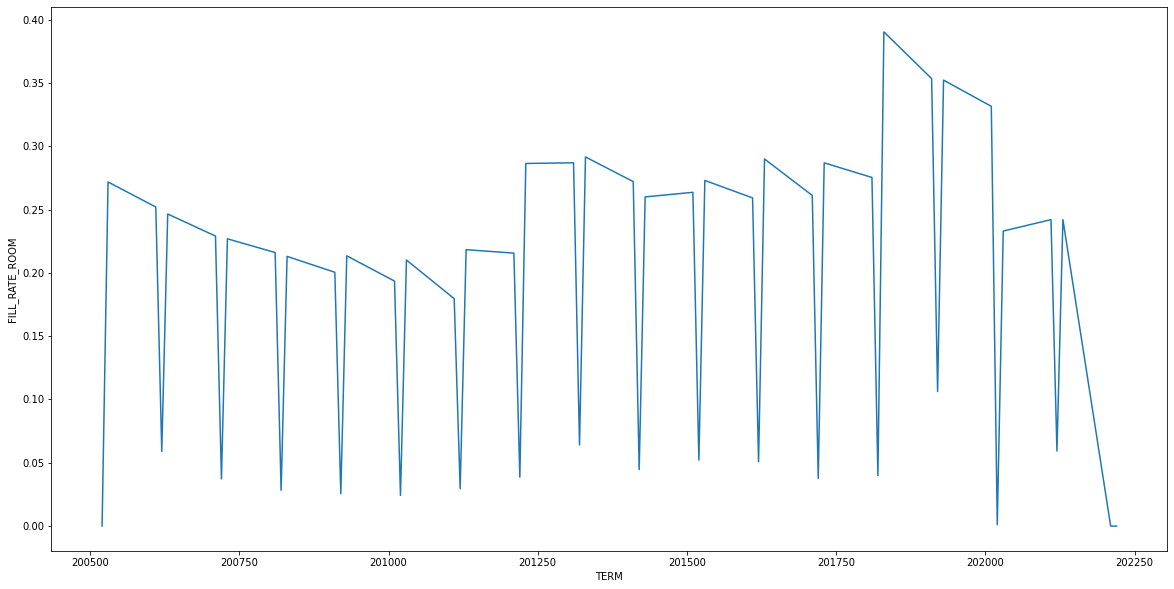

In [6]:
fill_rate_avgs['FILL_RATE_ROOM'].plot(ylabel='FILL_RATE_ROOM', figsize=(20,10))

#### Add `is_summer_term` column

In [7]:
# Since the summer_term field relies on the value of the TERM index,
# we need to temporarily remove the index from the df DataFrame
df.reset_index(inplace=True)

# Create the summer term filter function
def is_summer_term(term):
    return str(term)[-2:] == '20'

# Create new column is_summer_term in the DataFrame
df['is_summer_term'] = df['TERM'].apply(is_summer_term)

# Re-create index on TERM
df.set_index('TERM', drop=True, inplace=True)

#### Filter out summer terms

In [8]:
# Perform the filter on df using is_summer_term
no_summer_terms = df['is_summer_term'] == False
df = df[no_summer_terms]

#### Group by TERM, then find the mean FILL_RATE_ROOM in each group

In [9]:
fill_rate_avgs = df[['FILL_RATE_ROOM']].groupby('TERM').mean()

<AxesSubplot:xlabel='TERM'>

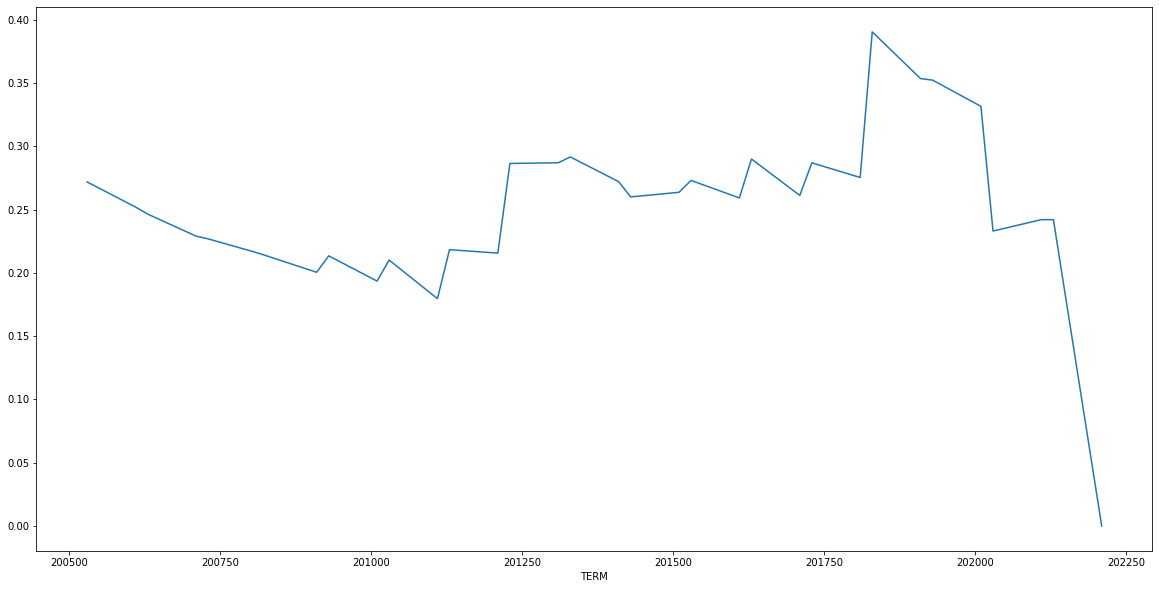

In [10]:
fill_rate_avgs['FILL_RATE_ROOM'].plot(figsize=(20,10))

#### Create a trend-line (regression plot) of the FILL_RATE_ROOM

<AxesSubplot:xlabel='TERM'>

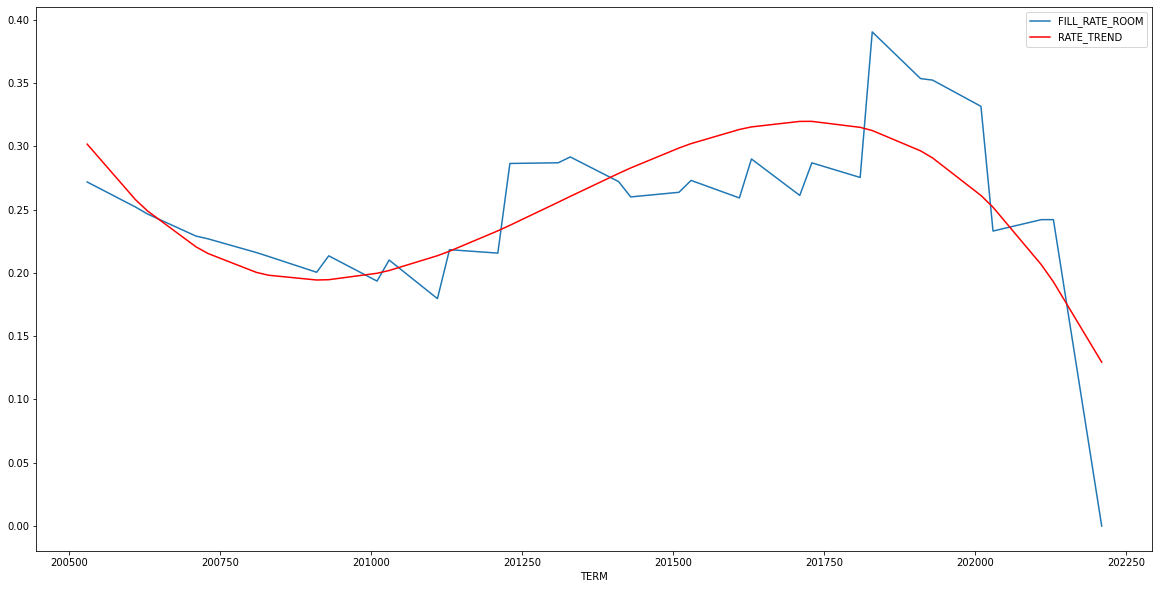

In [11]:
# Create the trendline function
d = np.polyfit(x=fill_rate_avgs.index, y=fill_rate_avgs['FILL_RATE_ROOM'], deg=3)
f = np.poly1d(d)

# Insert the trendline values into the fill_rate_avgs DataFrame
fill_rate_avgs.insert(1, 'RATE_TREND', f(fill_rate_avgs.index))

# Plot the fill_rate_avgs and its trend line
ax = fill_rate_avgs.plot(y='FILL_RATE_ROOM', figsize=(20,10))
fill_rate_avgs.plot(y='RATE_TREND', color='Red', ax=ax, figsize=(20,10))

### Bar graph of fill rate ranges

<AxesSubplot:>

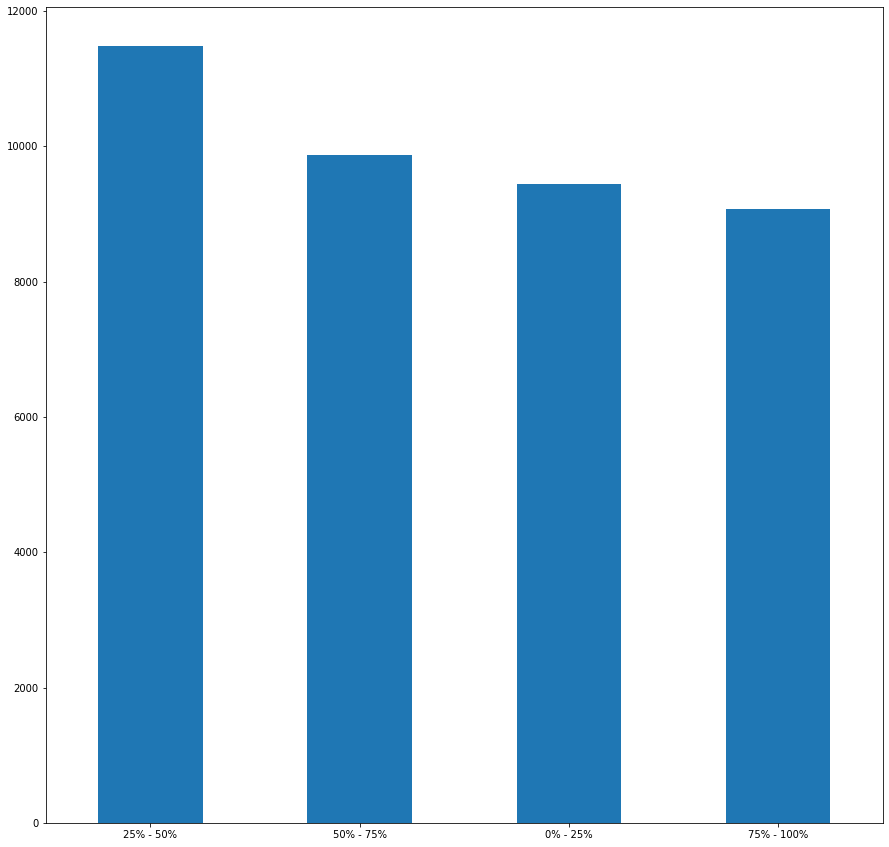

In [12]:
def rate_range(fill_rate_room):
    if fill_rate_room > 0 and fill_rate_room <= 0.25:
        return '0% - 25%'
    elif fill_rate_room > 0.25 and fill_rate_room <= 0.5:
        return '25% - 50%'
    elif fill_rate_room > 0.5 and fill_rate_room <= 0.75:
        return '50% - 75%'
    elif fill_rate_room > 0.75 and fill_rate_room <= 1:
        return '75% - 100%'

df['rate_range'] = df['FILL_RATE_ROOM'].apply(rate_range)

df['rate_range'].value_counts().plot(kind='bar', rot=0, figsize=(15, 15))  # set rot=0 so the x-axis labels are horizontal

#### Pie chart of Day Meetings

<AxesSubplot:ylabel='DAYS_MET'>

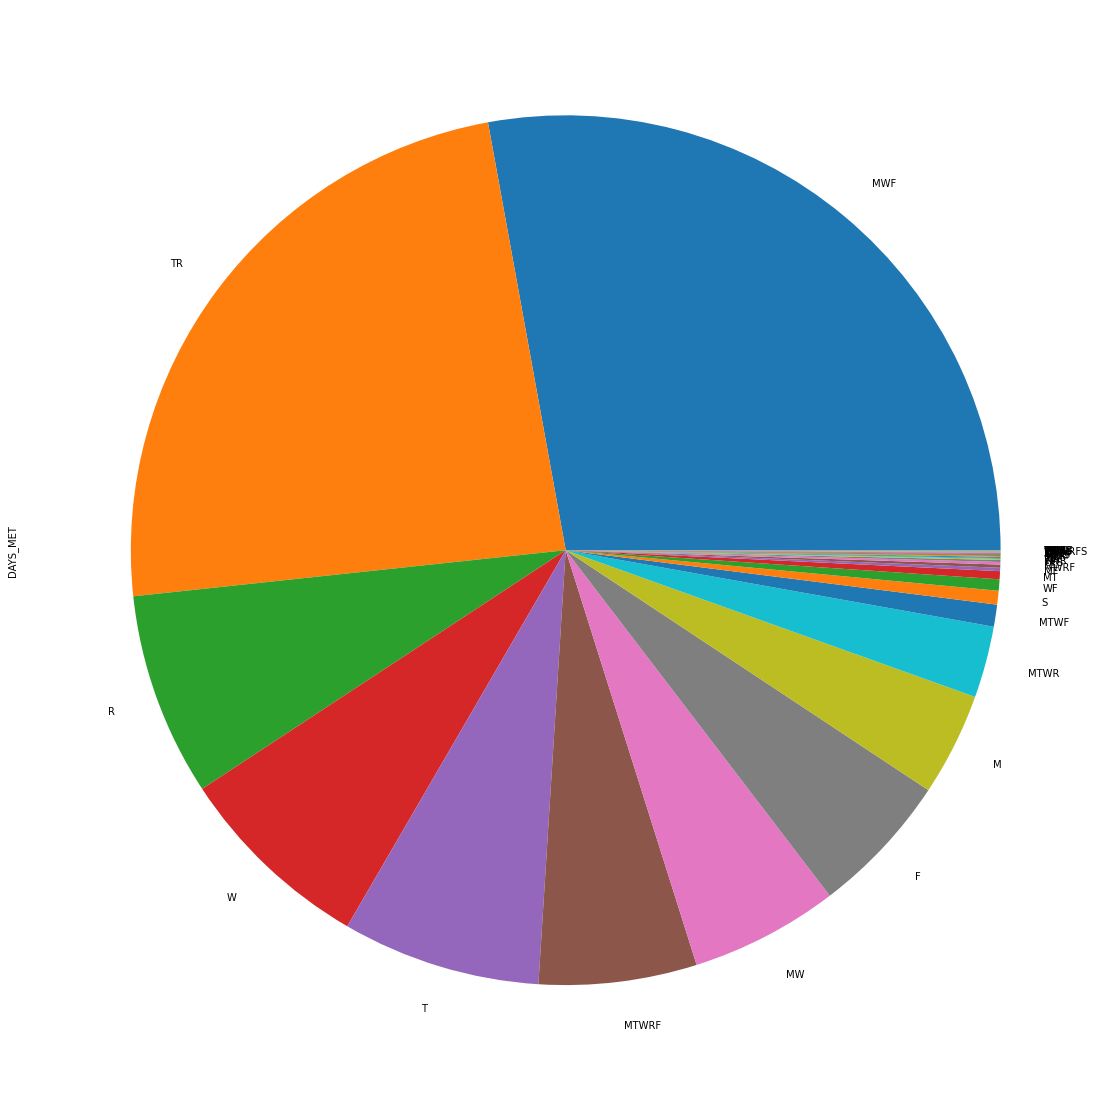

In [13]:
df['DAYS_MET'].value_counts().plot(kind='pie', figsize=(20,20))

#### Note: `df` now only includes Non-Summer terms

#### Only including the top 10 Day Meets in the Pie Chart

<AxesSubplot:ylabel='DAYS_MET'>

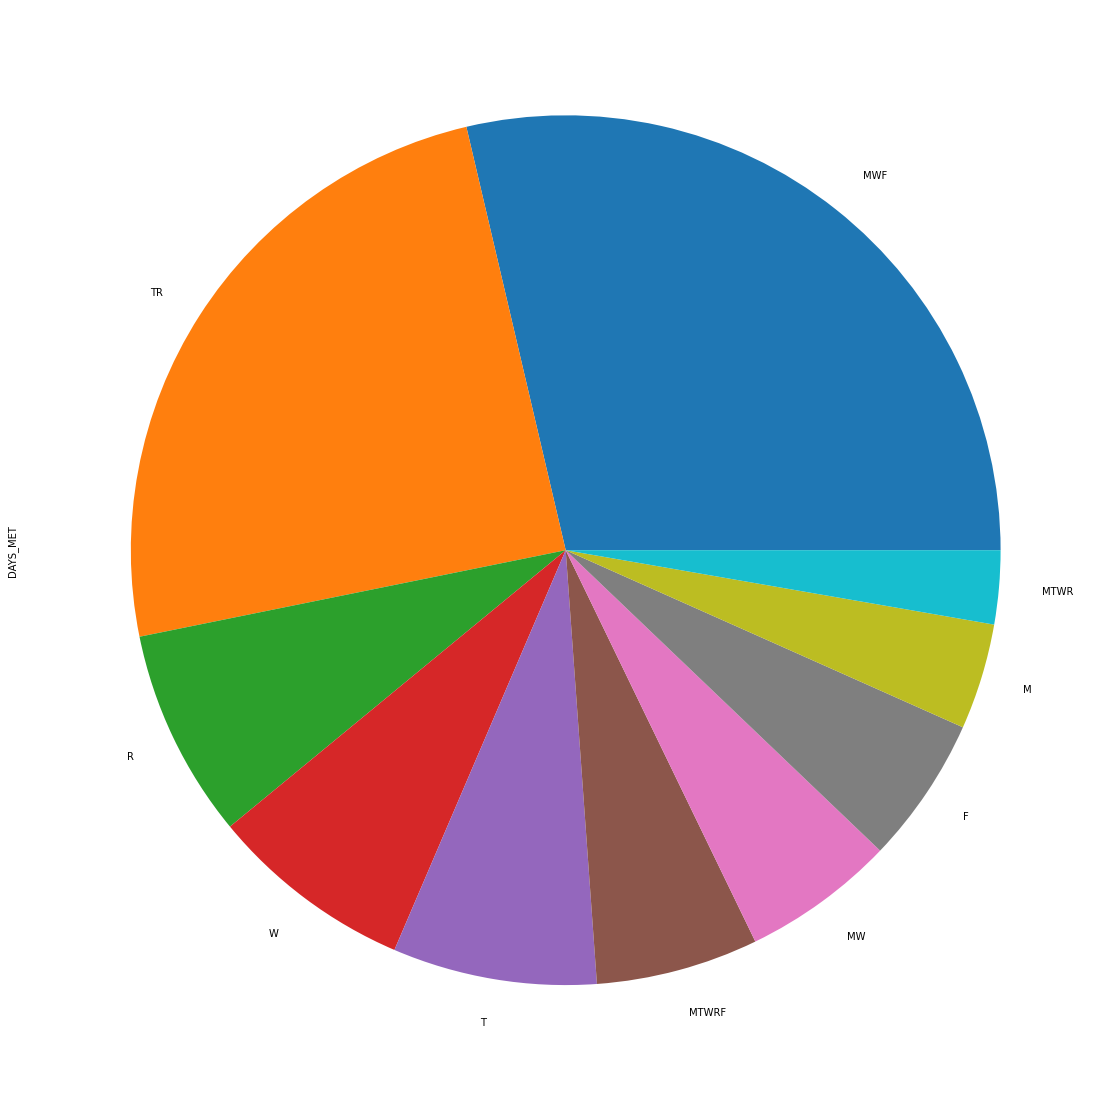

In [14]:
df['DAYS_MET'].value_counts().head(10).plot(kind='pie', figsize=(20,20))

In [15]:
next(df['DAYS_MET'].value_counts().items())

('MWF', 12841)

In [16]:
def count_to_percent(cnt):
    return cnt/df["DAYS_MET"].count() * 100

pie_labels = []

for (day_meet, cnt) in df['DAYS_MET'].value_counts().items():
    pie_labels.append(f'{day_meet}, {count_to_percent(cnt):.1f}%')

pie_labels

['MWF, 27.9%',
 'TR, 23.8%',
 'R, 7.6%',
 'W, 7.4%',
 'T, 7.4%',
 'MTWRF, 5.9%',
 'MW, 5.5%',
 'F, 5.3%',
 'M, 3.8%',
 'MTWR, 2.7%',
 'MTWF, 0.8%',
 'S, 0.5%',
 'WF, 0.4%',
 'MT, 0.3%',
 'MF, 0.1%',
 'MWRF, 0.1%',
 'FS, 0.1%',
 'UFS, 0.1%',
 'TWR, 0.0%',
 'WR, 0.0%',
 'RF, 0.0%',
 'MR, 0.0%',
 'MTR, 0.0%',
 'MTRF, 0.0%',
 'URFS, 0.0%',
 'US, 0.0%',
 'TWRF, 0.0%',
 'WRF, 0.0%',
 'MTWRFS, 0.0%',
 'TRF, 0.0%',
 'UMS, 0.0%',
 'MTW, 0.0%',
 'TW, 0.0%',
 'U, 0.0%',
 'WRFS, 0.0%',
 'TRS, 0.0%',
 'TWRS, 0.0%',
 'MWR, 0.0%',
 'WRS, 0.0%']

<AxesSubplot:ylabel='DAYS_MET'>

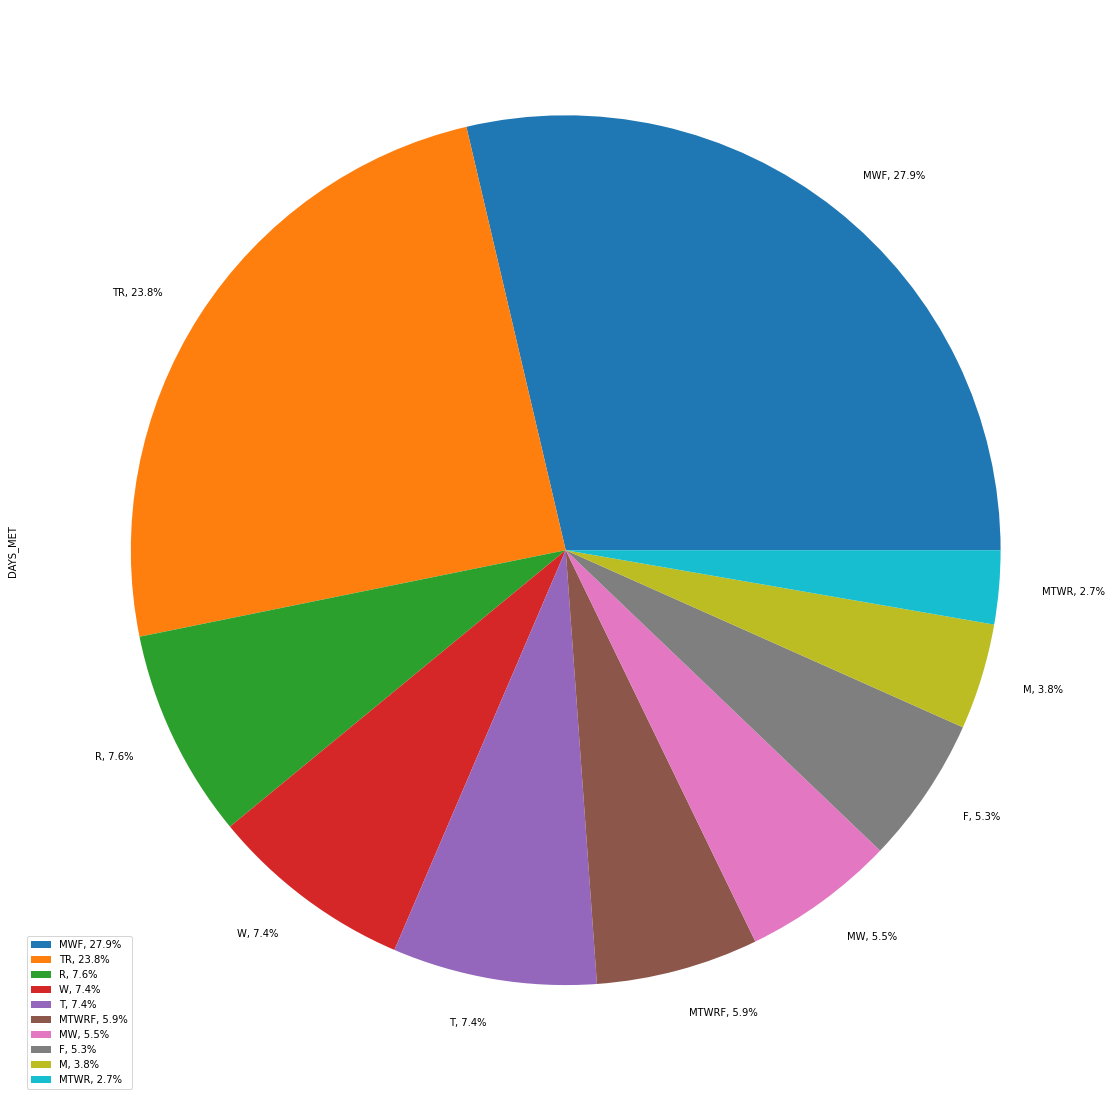

In [17]:
df['DAYS_MET'].value_counts().head(10).plot(kind='pie', figsize=(20,20), legend=True, labels=pie_labels)

# The End... thanks for coming to my talk